Training Metadata:
  participant_id    age     sex   study_site    bmi               ethnicity  \
0   NDARZE963MEU  15.33  Female  HBNsiteCBIC  28.52  Not_Hispanic_or_Latino   
1   NDARCB305AFY   9.43  Female  HBNsiteCBIC  16.23  Not_Hispanic_or_Latino   
2   NDARKK597VDH  13.85    Male  HBNsiteCBIC  16.27  Not_Hispanic_or_Latino   
3   NDARMR277TT7   9.68  Female    HBNsiteRU  16.55  Not_Hispanic_or_Latino   
4   NDARDB161LU6  12.79    Male  HBNsiteCBIC  14.27      Hispanic_or_Latino   

    race handedness parent_1_education  parent_2_education  p_factor_fs  \
0  White      Right  Complete_tertiary   Complete_tertiary         0.32   
1  White      Right  Complete_tertiary   Complete_tertiary        -1.48   
2  Other      Right  Complete_tertiary   Complete_tertiary         0.02   
3  Black       Left   Complete_primary   Complete_tertiary         1.29   
4  White      Right  Complete_tertiary  Complete_secondary        -0.15   

   internalizing_fs  externalizing_fs  attention_fs  
0

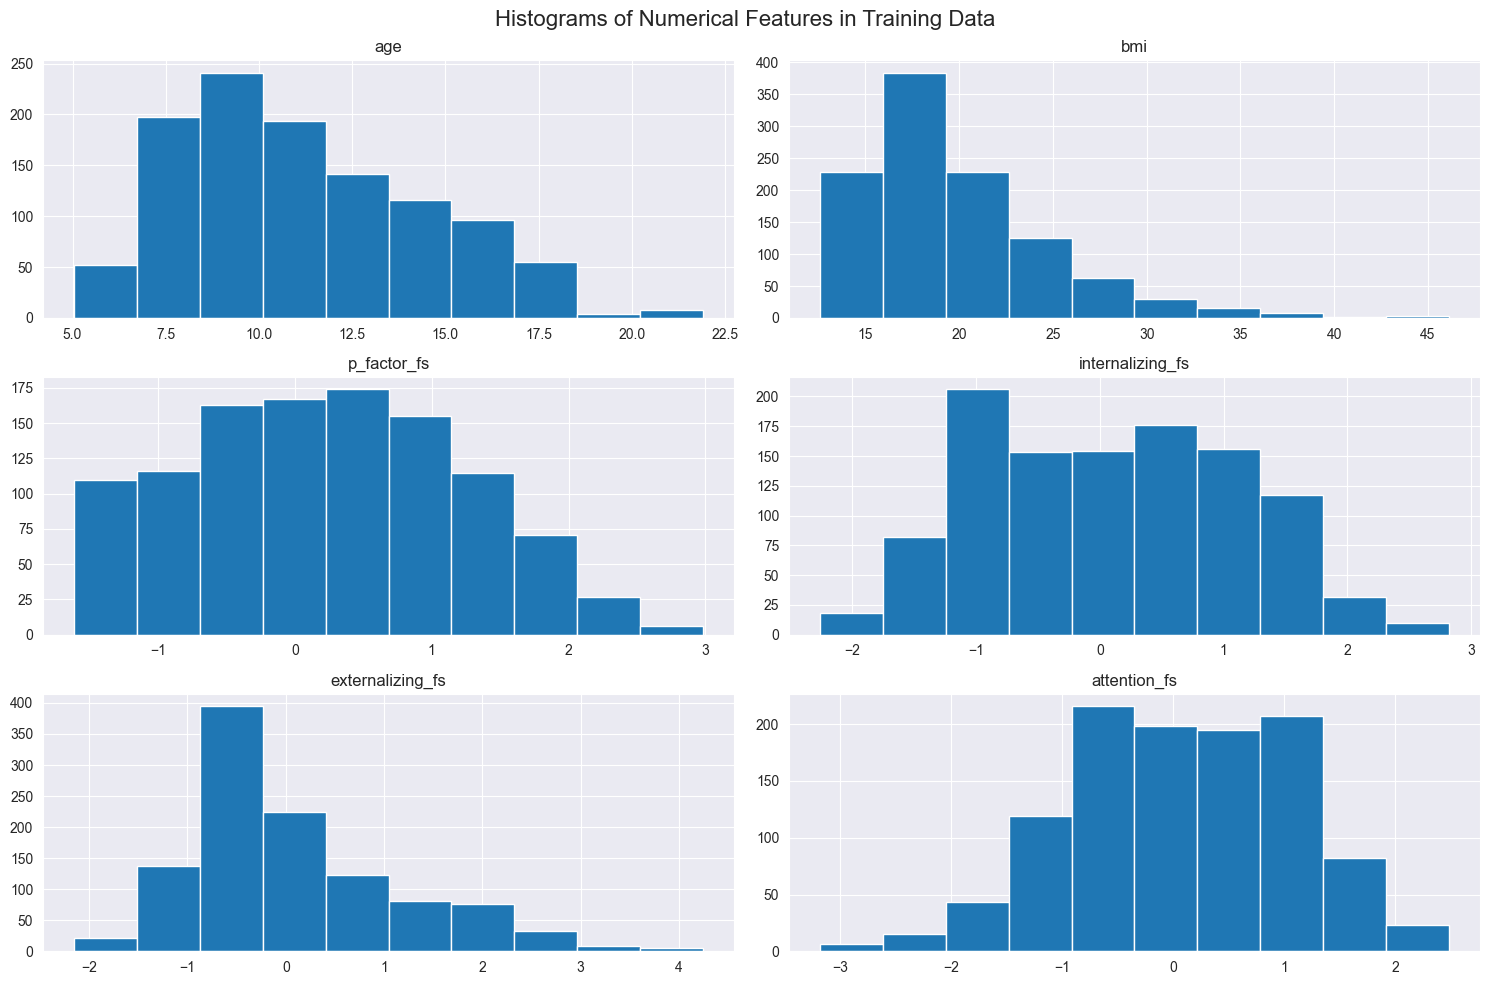

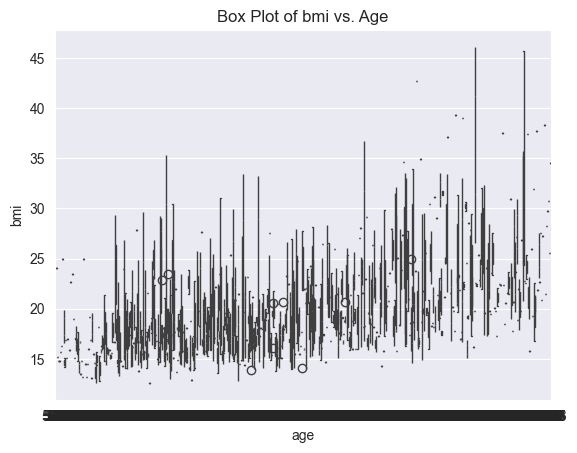

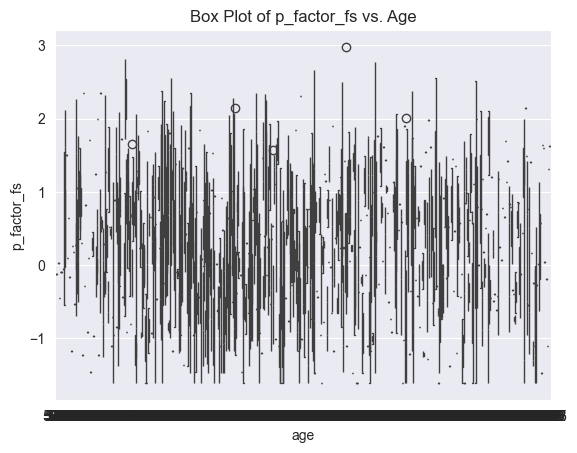

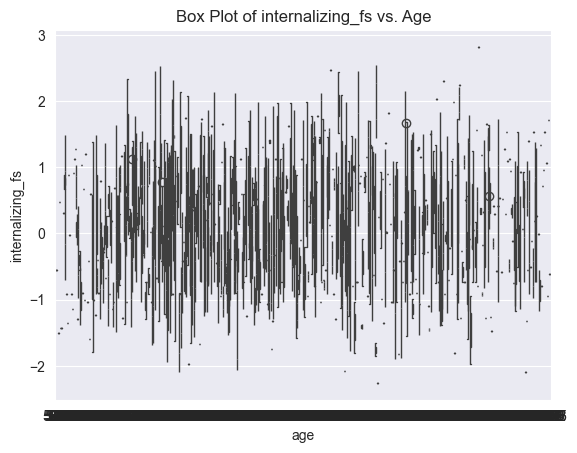

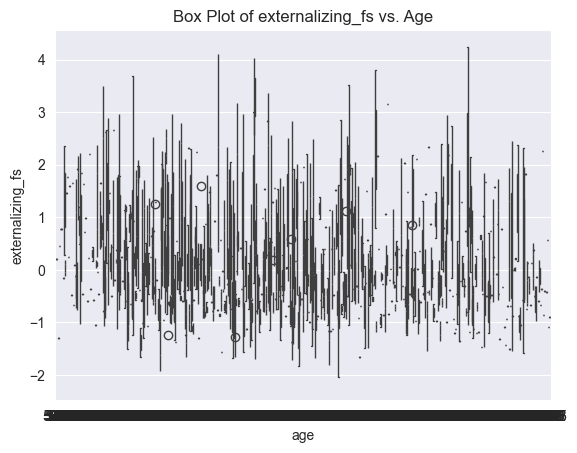

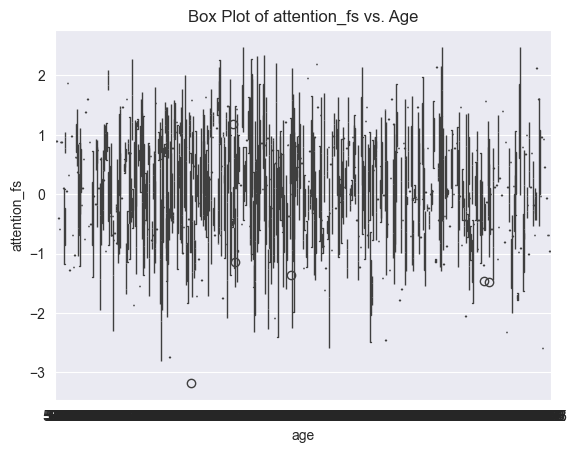

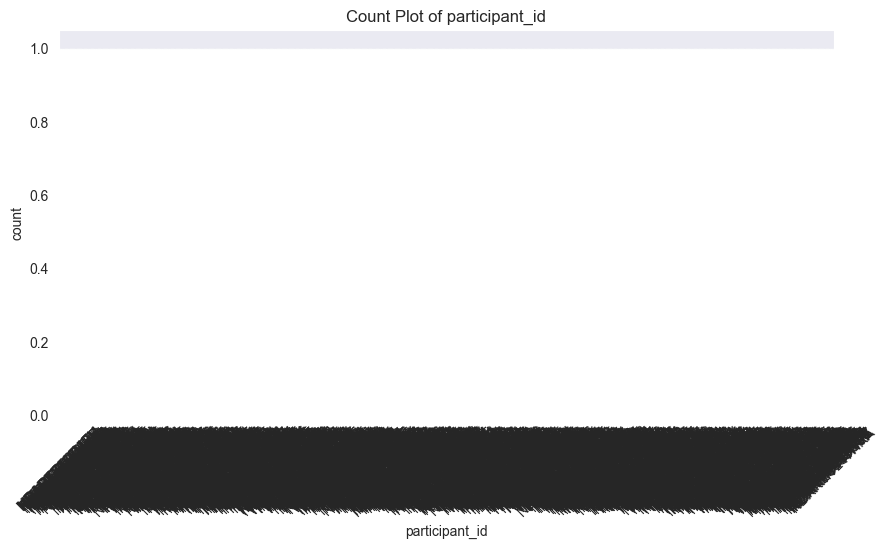

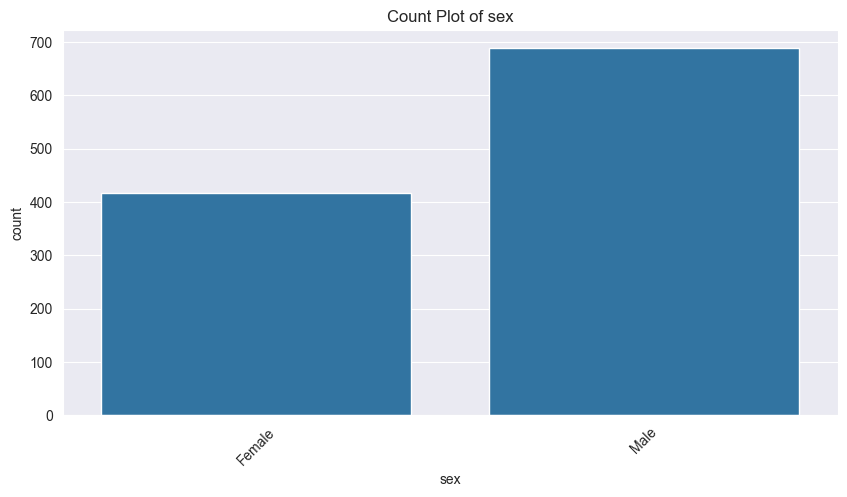

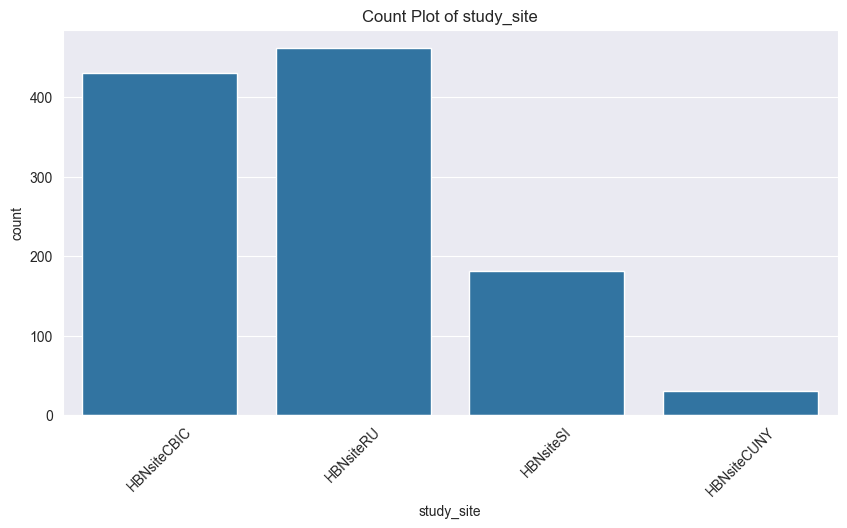

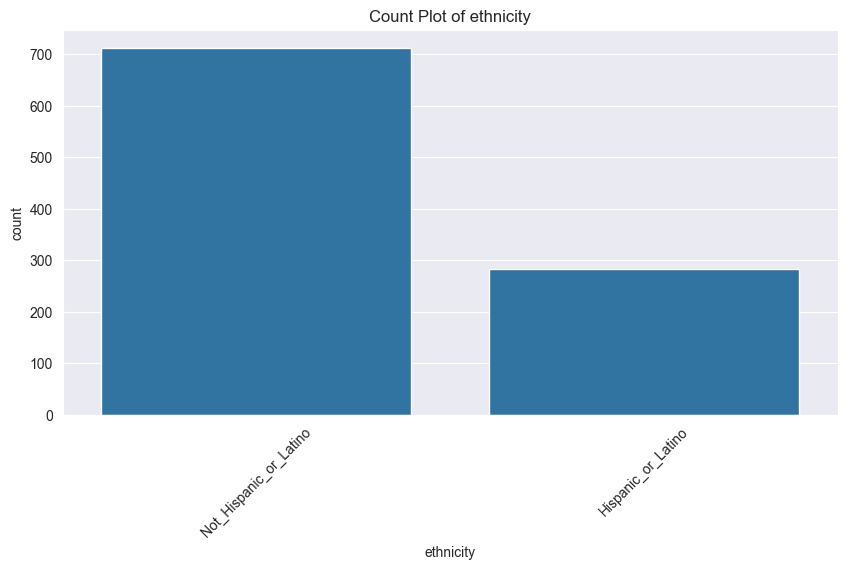

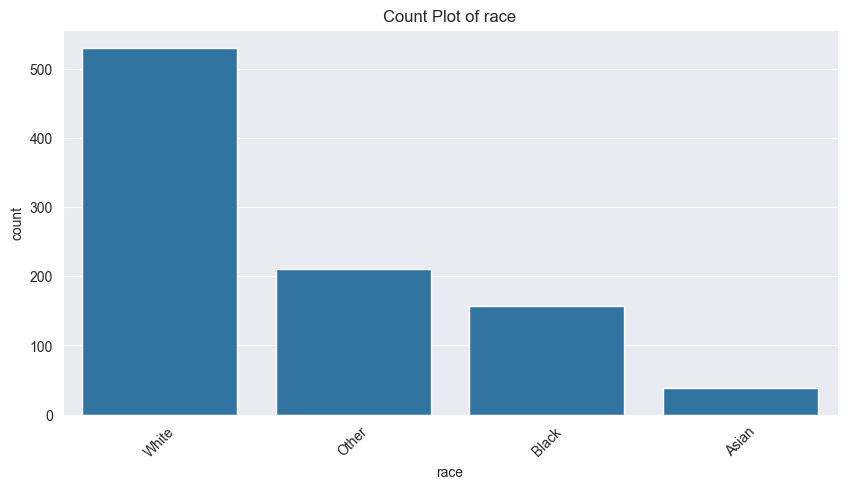

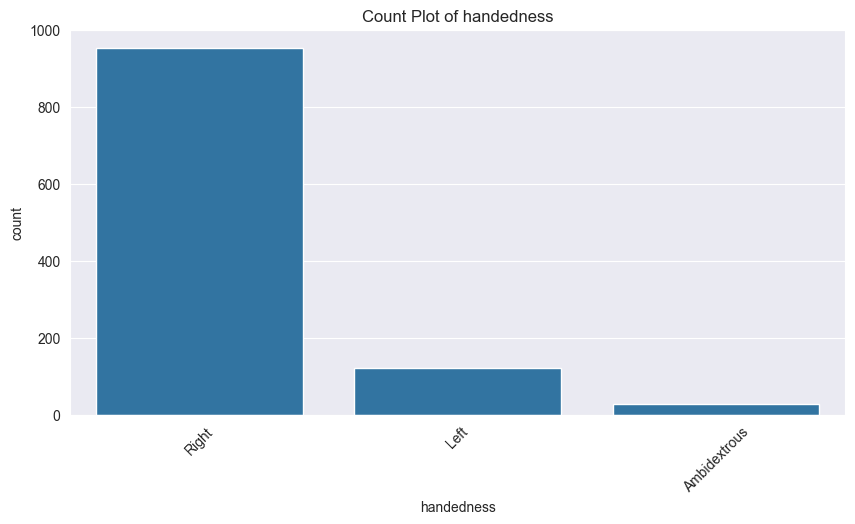

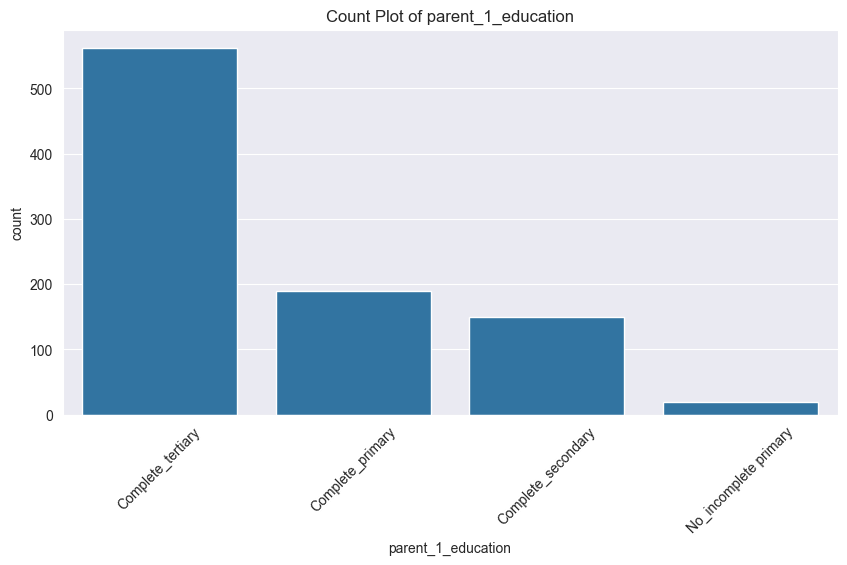

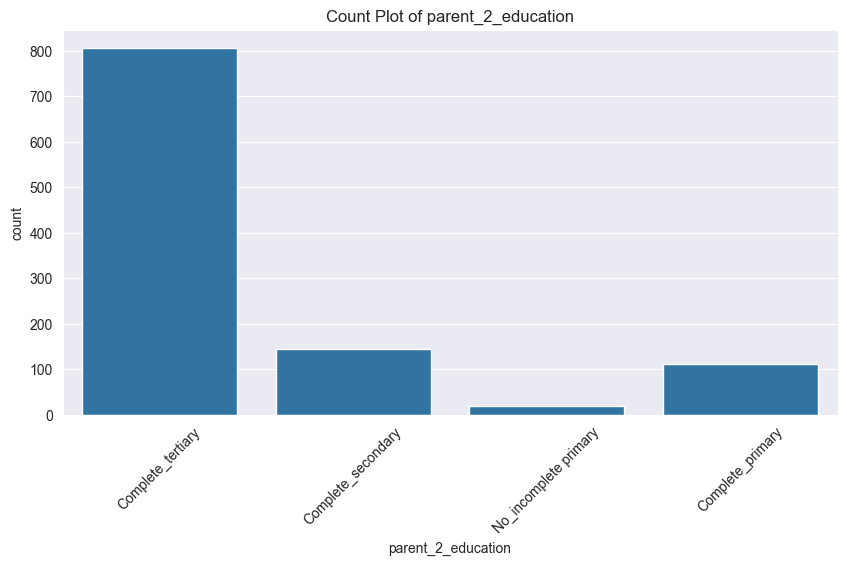

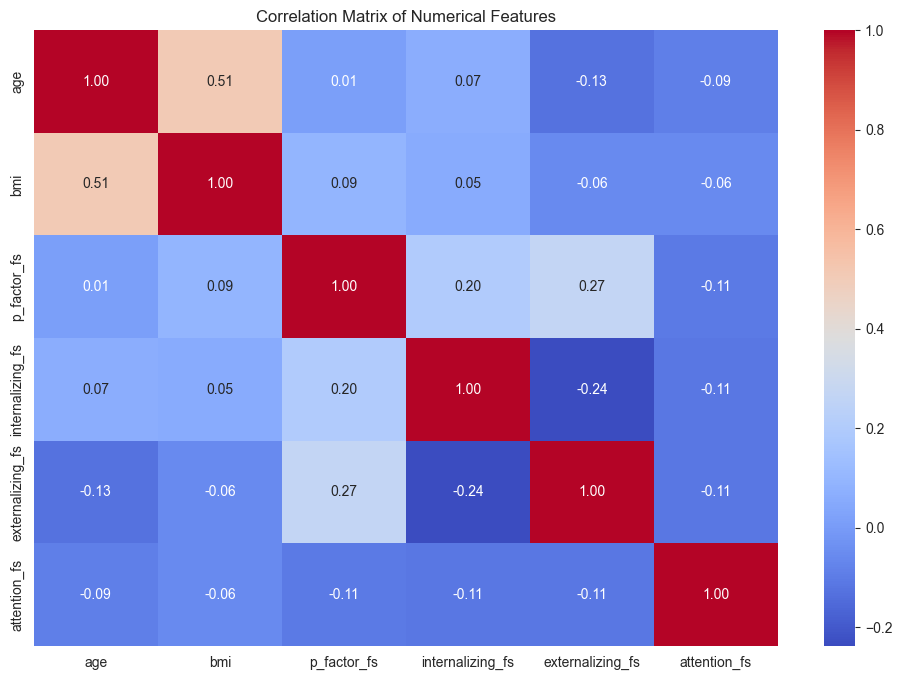

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import seaborn as sns
import optuna
from optuna.visualization import plot_slice
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import copy

# Local data paths
train_metadata_path = r'C:\Users\Tempest\PycharmProjects\FML-Project\widsdatathon2025-university\metadata\training_metadata.csv'
test_metadata_path = r'C:\Users\Tempest\PycharmProjects\FML-Project\widsdatathon2025-university\metadata\test_metadata.csv'
train_data_folder = r'C:\Users\Tempest\PycharmProjects\FML-Project\widsdatathon2025-university\train_tsv\train_tsv'
test_data_folder = r'C:\Users\Tempest\PycharmProjects\FML-Project\widsdatathon2025-university\test_tsv\test_tsv'

# Load the metadata
train_short = pd.read_csv(train_metadata_path)
test_short = pd.read_csv(test_metadata_path)

# Display the first few rows of the training metadata
print("Training Metadata:")
print(train_short.head())

# Display the first few rows of the test metadata
print("\nTest Metadata:")
print(test_short.head())

# Get basic information about the datasets
print("\nTraining Data Info:")
print(train_short.info())
print("\nTest Data Info:")
print(test_short.info())

# --- Data Visualization ---
# Histograms for numerical features in training data
train_short.hist(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features in Training Data', fontsize=16)
plt.tight_layout()
plt.show()

# Box plots for numerical features vs. target variable (age)
for col in train_short.select_dtypes(include=np.number):
    if col != 'age':  # Avoid plotting age against itself
        sns.boxplot(x='age', y=col, data=train_short)
        plt.title(f'Box Plot of {col} vs. Age')
        plt.show()

# Count plots for categorical features
for col in train_short.select_dtypes(include=['object']):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=train_short)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation matrix (heatmap) for numerical features
corr_matrix = train_short.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

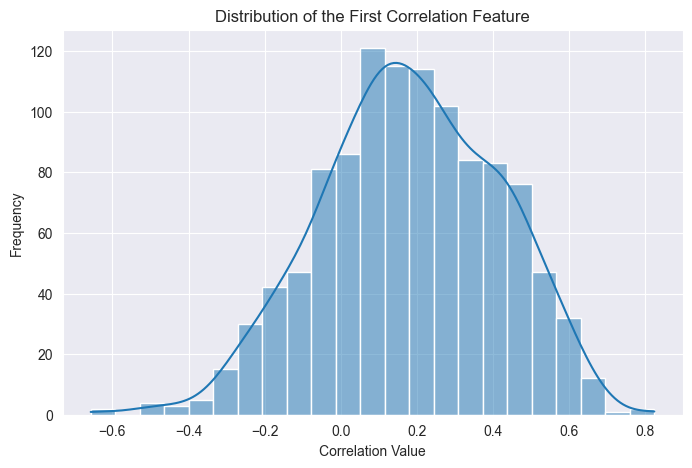

In [3]:
# Function to convert a matrix to a long row of unique correlations
def convert_matrix_to_long_row(matrix):
    if isinstance(matrix, np.ndarray):
        matrix = pd.DataFrame(matrix)
    upper_triangle = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))
    unique_correlations = upper_triangle.stack().dropna().unique()
    return pd.DataFrame(unique_correlations).T

# Function to generate column headers based on matrix dimensions
def generate_column_headers(matrix):
    rows, cols = matrix.shape
    return [f'{i}th_row_{j}th_column' for i in range(rows) for j in range(cols) if i < j]

# Function to process a folder of TSV files and create a DataFrame
def process_folder(source_folder, output_file):
    long_rows = []

    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)

        if os.path.isfile(file_path) and filename.endswith('.tsv'):
            try:
                # Specify the 'python' engine here
                matrix = pd.read_csv(file_path, sep='\t', header=None, engine='python')
                headers = ['participant_id'] + generate_column_headers(matrix)

                long_row = convert_matrix_to_long_row(matrix)
                extracted_id = filename.split('_')[0].replace('sub-', '')
                long_row.insert(0, "participant_id", extracted_id)

                long_rows.append(long_row)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    out_df = pd.concat(long_rows)
    out_df.columns = headers
    out_df.to_csv(output_file, sep='\t', index=False)
    return out_df

# Process train and test folders to create combined dataframes
output_file_train = 'train_correlations.tsv'
output_file_test = 'test_correlations.tsv'
train_big = process_folder(train_data_folder, output_file_train)
test_big = process_folder(test_data_folder, output_file_test)

# --- Data Visualization ---
# Example: Distribution of the first correlation feature
if train_big.shape[1] > 1:
    plt.figure(figsize=(8, 5))
    sns.histplot(train_big.iloc[:, 1], kde=True)  # Assuming the first column is 'participant_id'
    plt.title('Distribution of the First Correlation Feature')
    plt.xlabel('Correlation Value')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Not enough columns in train_big to visualize correlation feature distribution.")

# Merge dataframes
train = pd.merge(train_big, train_short, on='participant_id', how='outer')
test = pd.merge(test_big, test_short, on='participant_id', how='outer')

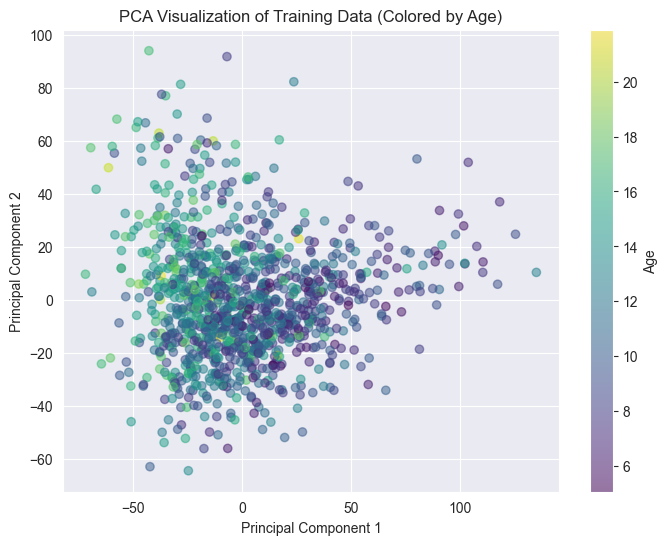

In [4]:
# Define X_train, y_train, X_test
X_train = train.drop(columns=['participant_id', 'age'])
y_train = train['age']
X_test = test.drop(columns=['participant_id'])  # No 'age' column in the test set

# 1. Handle Missing Values in Categorical Columns
categorical_cols = ['sex', 'study_site', 'ethnicity', 'race', 'handedness', 'parent_1_education', 'parent_2_education']
X_train[categorical_cols] = X_train[categorical_cols].fillna("Unknown")
X_test[categorical_cols] = X_test[categorical_cols].fillna("Unknown")

# 2. Impute Numerical Columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
imputer_num = SimpleImputer(strategy='mean')
X_train[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer_num.transform(X_test[numerical_cols])

# 3. Convert Categorical Columns to Strings
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# 4. One-Hot Encode Categorical Columns
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_cols]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_cols]).toarray()

# 5. Convert Encoded Data to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# 6. Drop Original Categorical Columns (NOW, after imputation and encoding)
X_train_numerical = X_train.drop(categorical_cols, axis=1)
X_test_numerical = X_test.drop(categorical_cols, axis=1)

# 7. Combine Encoded and Numerical Columns
X_train_final = pd.concat([X_train_numerical, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_numerical, X_test_encoded_df], axis=1)

# 8. Scale Numerical Features
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

# --- Data Visualization ---
# Example: PCA to visualize the high-dimensional data in 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_final)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(label='Age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Training Data (Colored by Age)')
plt.show()

Train-Test Split Explanation:
The train_test_split function divides the dataset into training and validation sets.
  - X_train_final (shape: (883, 19925)): Features for training the model.
  - y_train_final (shape: (883,)): Target variable (age) for training.
  - X_val_final (shape: (221, 19925)): Features for validating the trained model.
  - y_val_final (shape: (221,)): Target variable (age) for validation.
  - test_size=0.2: 20% of the data is used for validation, 80% for training.
  - random_state=42: Ensures consistent splitting for reproducibility.

Linear Regression Metrics:
MAE: 1.701101569087677
RMSE: 2.065360390352125
R^2: 0.5527625816674155
  - MAE (Mean Absolute Error): Average absolute difference between predicted and actual ages.
  - RMSE (Root Mean Squared Error): Square root of the average squared difference.
  - R^2 (Coefficient of Determination): Proportion of variance in age explained by the model. Higher is better (up to 1).

Ridge Regression Metrics:
MAE: 1.7010642

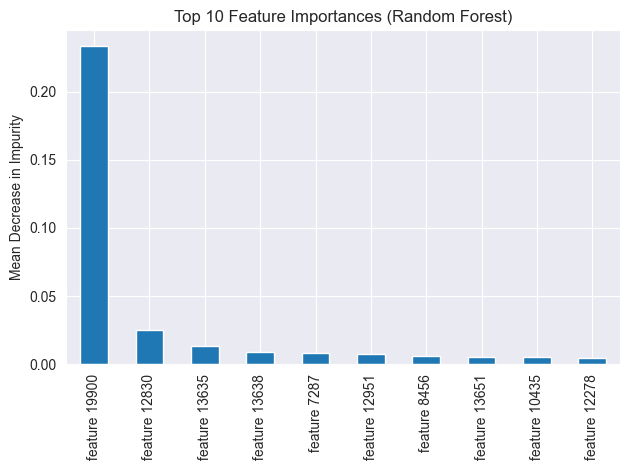

Feature Importance:
  - This plot shows the relative importance of the top 10 features in the Random Forest model.
  - Higher values indicate features that contribute more to the model's predictions.



In [5]:
# Splitting the dataset into the Training set and Validation set
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42
)

# --- Explanation of Train-Test Split ---
print("Train-Test Split Explanation:")
print(
    "The train_test_split function divides the dataset into training and validation sets."
)
print(f"  - X_train_final (shape: {X_train_final.shape}): Features for training the model.")
print(f"  - y_train_final (shape: {y_train_final.shape}): Target variable (age) for training.")
print(
    f"  - X_val_final (shape: {X_val_final.shape}): Features for validating the trained model."
)
print(
    f"  - y_val_final (shape: {y_val_final.shape}): Target variable (age) for validation."
)
print(
    "  - test_size=0.2: 20% of the data is used for validation, 80% for training."
)
print(
    "  - random_state=42: Ensures consistent splitting for reproducibility.\n"
)

# --- Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train_final)
y_pred_lin = lin_reg.predict(X_val_final)

# Evaluate Linear Regression
print("Linear Regression Metrics:")
print("MAE:", mean_absolute_error(y_val_final, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_val_final, y_pred_lin)))
print("R^2:", r2_score(y_val_final, y_pred_lin))
print(
    "  - MAE (Mean Absolute Error): Average absolute difference between predicted and actual ages."
)
print("  - RMSE (Root Mean Squared Error): Square root of the average squared difference.")
print("  - R^2 (Coefficient of Determination): Proportion of variance in age explained by the model. Higher is better (up to 1).\n")

# --- Ridge Regression (L2 Regularization) ---
ridge_reg = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge_reg.fit(X_train_final, y_train_final)
y_pred_ridge = ridge_reg.predict(X_val_final)

# Evaluate Ridge Regression
print("Ridge Regression Metrics:")
print("MAE:", mean_absolute_error(y_val_final, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_val_final, y_pred_ridge)))
print("R^2:", r2_score(y_val_final, y_pred_ridge))
print("  - Ridge Regression is similar to Linear Regression but adds a penalty to large coefficients to prevent overfitting.\n")

# --- Random Forest Regressor ---
# Check for CUDA (GPU) availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

# Modify Random Forest to potentially use GPU via joblib (if compatible)
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)  # n_jobs=-1 uses all cores
# Note: joblib might not directly leverage the GPU for Random Forest in scikit-learn.
# For true GPU acceleration with Random Forests, consider libraries like cuML (RAPIDS).

rf_reg.fit(X_train_final, y_train_final)
y_pred_rf = rf_reg.predict(X_val_final)

# Evaluate Random Forest
print("Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_val_final, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val_final, y_pred_rf)))
print("R^2:", r2_score(y_val_final, y_pred_rf))
print("  - Random Forest is an ensemble method that combines multiple decision trees for improved accuracy and robustness.\n")

# --- Feature Importance Visualization (Reduced) ---
# Only display top 10 most important features
importances = rf_reg.feature_importances_
feature_names = [f"feature {i}" for i in range(X_train_final.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

# Sort and select top 10
top_10_features = forest_importances.sort_values(ascending=False).head(10)

fig, ax = plt.subplots()
top_10_features.plot.bar(ax=ax)
ax.set_title("Top 10 Feature Importances (Random Forest)")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

print("Feature Importance:")
print("  - This plot shows the relative importance of the top 10 features in the Random Forest model.")
print("  - Higher values indicate features that contribute more to the model's predictions.\n")

In [7]:
from sklearn.model_selection import GridSearchCV, KFold

# --- Hyperparameter Tuning for Random Forest (Optimized for Speed) ---

# 1. Define a smaller parameter grid
# Reduced for faster execution, especially when not using GPU directly
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# 2. Initialize the Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)  # Use all cores

# 3. Initialize KFold for cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced number of splits

# 4. Initialize GridSearchCV (with reduced verbosity)
grid_search = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid,
    cv=kf,
    n_jobs=-1,
    verbose=1,  # Reduced verbosity
    scoring="neg_mean_squared_error",
)

# 5. Fit GridSearchCV to the data (potentially faster with a smaller grid)
grid_search.fit(X_train_final, y_train_final)

# 6. Best parameters and model evaluation
print("Best parameters found:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
scores = cross_val_score(
    best_rf_model,
    X_train_final,
    y_train_final,
    scoring="neg_mean_squared_error",
    cv=kf,
)
rmse_scores = np.sqrt(-scores)

print("Cross-validation RMSE scores:", rmse_scores)
print("Average cross-validation RMSE:", rmse_scores.mean())

# --- Final Model Training and Predictions ---

# 1. Train the final model (using the best hyperparameters)
final_model = RandomForestRegressor(
    **grid_search.best_params_, random_state=42, n_jobs=-1
)
final_model.fit(
    X_train_final, y_train_final
)  # Train on the training data, not the entire data

# 2. Make predictions on the test set
final_predictions = final_model.predict(X_test_final)

# 3. Create a submission DataFrame
submission_df = pd.DataFrame(
    {"participant_id": test_short["participant_id"], "age": final_predictions}
)

# 4. Save predictions to a CSV file
submission_df.to_csv("submission.csv", index=False)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Cross-validation RMSE scores: [2.5137875  2.45781608 2.47313886]
Average cross-validation RMSE: 2.481580809678619
